# Необходимо переключиться на среду выполнения с GPU


#Импорты и зависимости

In [ ]:
!pip install -q torchmetrics[detection]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
import torchvision
from skimage.transform import resize
from torchvision.transforms import v2 as T
from torchvision.utils import save_image
from torch.utils.data import random_split
from torchvision.utils import draw_bounding_boxes

from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights
from torchvision.ops import box_iou, complete_box_iou, complete_box_iou_loss

from torchmetrics.detection import MeanAveragePrecision
from torchmetrics.detection import IntersectionOverUnion

import sys
import os
from time import time
from skimage.io import imread
from matplotlib import rcParams
from PIL import Image
from google.colab import files
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Загрузка данных

In [ ]:
!pip install xmltodict
import xmltodict

In [ ]:
files.upload() #сюда необходимо загрузить файл kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vekosek","key":"173fa957980f67a4143755f1e9b0c6d4"}'}

Удобненько раскидываем все по каталогам

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d sbaghbidi/human-faces-object-detection
!unzip /content/human-faces-object-detection.zip
!rm /content/human-faces-object-detection.zip
!mkdir input
!mv images /content/input
!mv faces.csv /content/input

 98% 487M/498M [00:06<00:00, 96.1MB/s]
100% 498M/498M [00:06<00:00, 82.9MB/s]


# Dataset и Dataloader

In [ ]:
IMG_SIZE = 640
BATCH_SIZE = 8

In [ ]:
transformer = transforms.Compose([transforms.ToTensor(),
                       transforms.RandomRotation(degrees=(-5,5)),
                       transforms.Resize((IMG_SIZE,IMG_SIZE)),
                       transforms.Normalize([0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])

In [ ]:
annotations = pd.read_csv('/content/input/faces.csv')

In [ ]:
annotations.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [ ]:
class Photos(torch.utils.data.Dataset):
    def __init__(self, root, ann, size, transform):
        self.root = root
        self.images = os.listdir(self.root)
        self.annotations = ann
        self.size = size
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx]))
        kx = self.size / img.size[0]
        ky = self.size / img.size[1]

        annotation_set = self.annotations.loc[self.annotations['image_name'] ==
                                              self.images[idx]]
        num_objs = len(list(annotation_set['image_name']))

        # Bounding boxes для каждого объекта
        # Формат: [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = list(annotation_set['x0'])[i]
            ymin = list(annotation_set['y0'])[i]
            xmax = list(annotation_set['x1'])[i]
            ymax = list(annotation_set['y1'])[i]
            bwidth = xmax - xmin
            bheight = ymax - ymin
            x1 = xmin * kx
            y1 = ymin * ky
            w = bwidth * kx
            h = bheight * ky
            boxes.append([x1, y1, x1 + w, y1 + h])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor([1] * num_objs)

        # Переводим аннотации в словарь
        new_annotation = {}
        new_annotation["boxes"] = boxes
        new_annotation["labels"] = labels

        return self.transform(img), new_annotation

    # Определяем для класса функцию len
    def __len__(self):
        return len(self.images)

In [ ]:
photos = Photos('/content/input/images/', annotations, IMG_SIZE, transformer)

In [ ]:
train_dataset, valid_dataset, test_dataset = random_split(photos, [0.7, 0.15, 0.15])
dataset_list = {'train': train_dataset, 'val': valid_dataset}
dataloaders = {status: torch.utils.data.DataLoader(dataset_list[status],
                                             batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2,
                                             collate_fn=lambda batch: tuple(zip(*batch)))
                                             for status in ['train', 'val']}

Смотрим на изображения и bounding boxes

In [ ]:
def format_image(image):
  return (255.0 * (image - image.min()) /
         (image.max() - image.min())).to(torch.uint8)

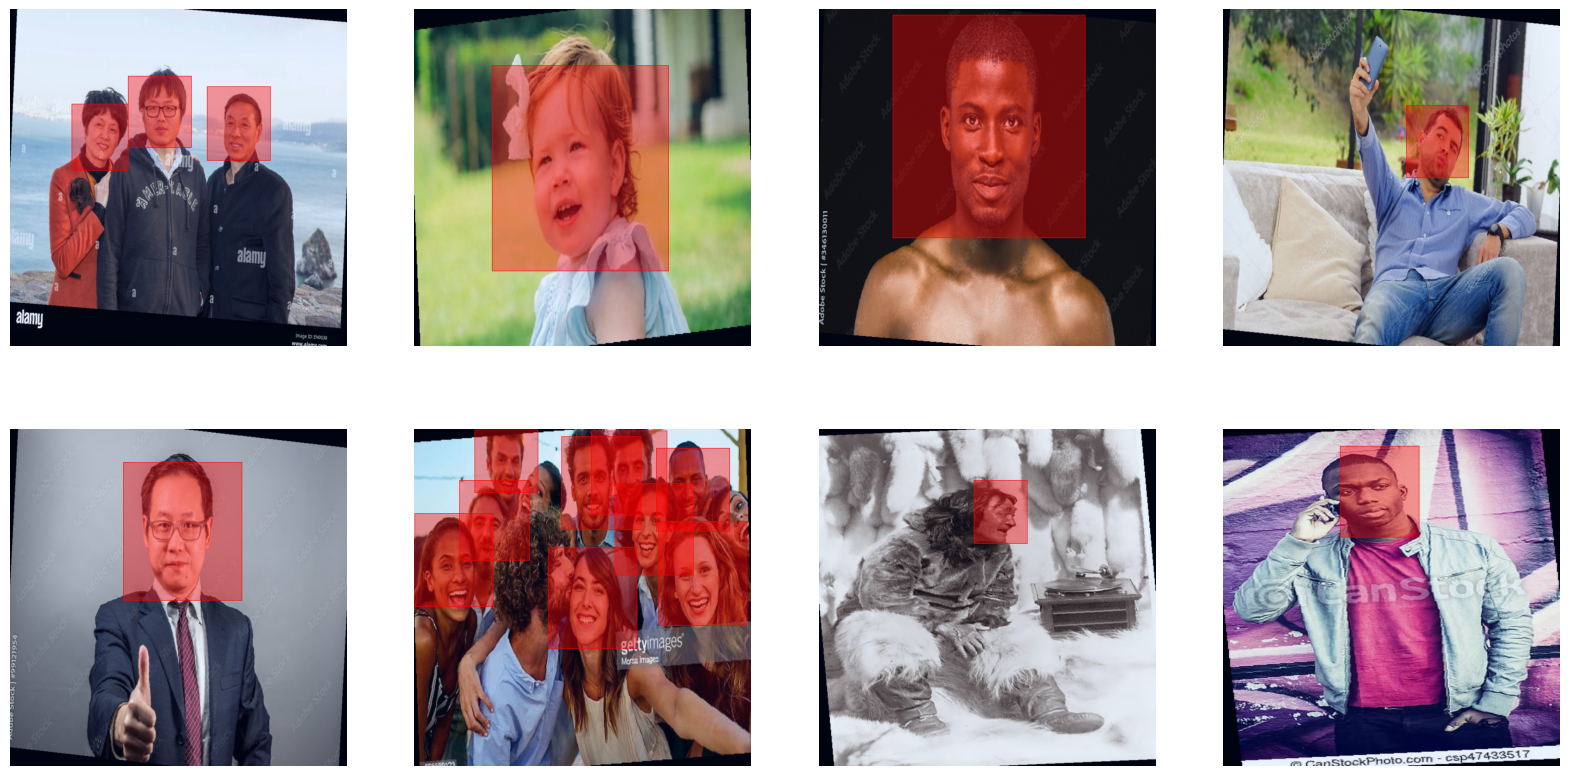

In [ ]:
index = np.random.randint(0, len(photos), 8)
fig = plt.figure(figsize=(20,10))
for i in range(len(index)):
    fig.add_subplot(2, 4, i+1)
    data = photos[index[i]]
    look = data[0]
    # Отменяем нормализацию
    look = format_image(look)
    boxes = data[1]['boxes']
    result = draw_bounding_boxes(look, boxes,
                                 fill=True, width=1,
                                 colors=['red']*len(boxes)).permute(1, 2, 0)
    plt.axis("off")
    plt.imshow(result)
plt.show()

# Модель

Используем предобученную модель SSD с классификатором VGG16



score_thresh = .25 - порог для вероятноятности, при котором мы уверены, что объект найден.

In [ ]:
ssd = models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT,
                                    weights_backbone=models.VGG16_Weights,
                                    pretrained=True, score_thresh = .25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=VGG16_Weights.IMAGENET1K_FEATURES`. You can also use `weights_backbone=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def create_model(model, num_classes=2, size=IMG_SIZE):
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    num_anchors = model.anchor_generator.num_anchors_per_location()
    model.head.classification_head = SSDClassificationHead(
       in_channels=in_channels,
       num_anchors=num_anchors,
       num_classes=num_classes,
     )

    model.transform.min_size = (size,)
    model.transform.max_size = size
    return model

model = create_model(ssd)

In [ ]:
model

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# Тренировка

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 3

In [ ]:
model = model.to(device)

In [ ]:
train_itr = 1
val_itr = 1
def train(train_data_loader, model):
    model.train()
    print('--- Тренировка ---')
    global train_itr
    global train_loss_list

    # Прогресс бар обучения
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        # Основной код обучения
        optimizer.zero_grad()
        images, targets = data
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        current_loss = losses.item()
        train_loss_list.append(current_loss)
        losses.backward()
        optimizer.step()

        train_itr += 1

        # Апдейт прогресс бара
        prog_bar.set_description(desc=f"Loss: {current_loss:.4f}")
    return train_loss_list

In [ ]:
def validate(valid_data_loader, model):
    print('--- Валидация ---')
    global val_itr
    global val_loss_list

    # Прогресс бар
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
      images, targets = data
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      with torch.no_grad():
        # Сичтаем лосс
        model.train()
        loss_dict = model(images, targets)
        metric = MeanAveragePrecision(iou_type="bbox")
        # Ситаем метрику MAP_50
        model.eval()
        output = model(images, targets)
        metric.update(output, targets)
        map_metric = metric.compute()['map_50']

      losses = sum(loss for loss in loss_dict.values())
      current_loss = losses.item()
      val_loss_list.append(current_loss)
      val_itr += 1

      # Апдейт прогресс бара
      prog_bar.set_description(desc=f"Loss: {current_loss:.4f}---mAP50: {map_metric:.4f}")
    return val_loss_list

In [ ]:
train_loss_list = []
val_loss_list = []

# Полный цикл обучения по эпохам
for epoch in range(num_epochs):
    print(f"\nEPOCH {epoch+1} of {num_epochs}")

    # Таймер
    start = time()
    train_loss = train(dataloaders['train'], model)
    val_loss = validate(dataloaders['val'], model)
    end = time()

    print(f"Epoch #{epoch+1}")
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")


EPOCH 1 of 3
--- Тренировка ---


  0%|          | 0/166 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Loss: 3.6107: 100%|██████████| 166/166 [02:18<00:00,  1.89it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Loss: 3.6107: 100%|██████████| 166/166 [02:18<00:00,  1.20it/s]


--- Валидация ---


Loss: 2.2672---mAP50: 1.0000: 100%|██████████| 56/56 [00:49<00:00,  1.13it/s]


Epoch #1
Epoch #1
Took 3.140 minutes for epoch 1

EPOCH 2 of 3
--- Тренировка ---


Loss: 2.7900: 100%|██████████| 166/166 [02:17<00:00,  1.21it/s]


--- Валидация ---


Loss: 1.8245---mAP50: 1.0000: 100%|██████████| 56/56 [00:48<00:00,  1.15it/s]


Epoch #2
Epoch #2
Took 3.095 minutes for epoch 2

EPOCH 3 of 3
--- Тренировка ---


Loss: 1.7560: 100%|██████████| 166/166 [02:18<00:00,  1.20it/s]


--- Валидация ---


Loss: 4.1196---mAP50: 1.0000: 100%|██████████| 56/56 [00:50<00:00,  1.11it/s]

Epoch #3
Epoch #3
Took 3.147 minutes for epoch 3


Визуализируем процесс обучения

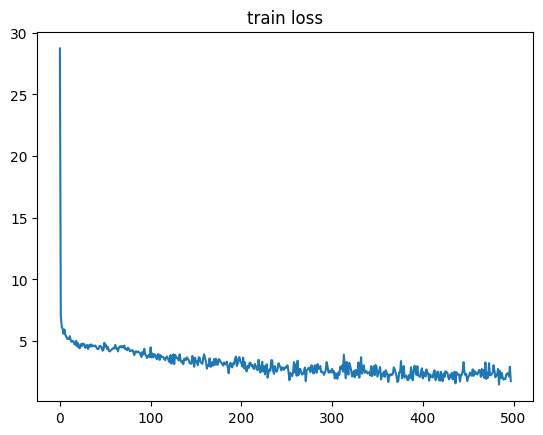

In [ ]:
plt.plot(train_loss)
plt.title('train loss')
plt.show()

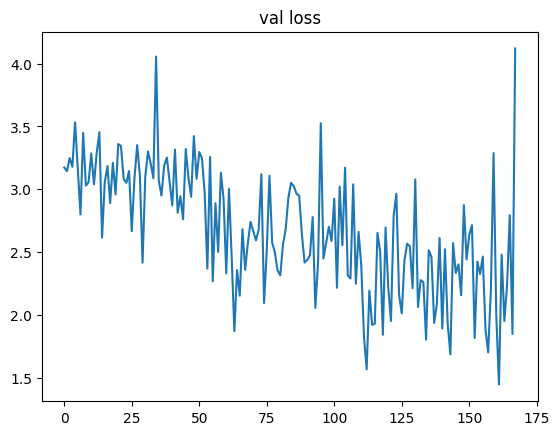

In [ ]:
plt.plot(val_loss)
plt.title('val loss')
plt.show()

# Визуализация работы

In [ ]:
def draw_bb(input, model):
    image = input[0]
    with torch.no_grad():
        predictions = model.eval()([image.to(device),])
    pred = predictions[0]

    image = format_image(image)

    pred_label = [f"predicted face" for label in pred["labels"]]
    true_label = [f"true face" for label in input[1]["labels"]]
    pred_boxes = pred["boxes"].long()
    true_boxes = input[1]['boxes'].long()

    output_image = draw_bounding_boxes(image, pred_boxes, pred_label, fill=True,
                                       colors=['blue']*len(pred_label),
                                       width=1)
    output_image = draw_bounding_boxes(output_image, true_boxes, true_label,
                                       fill=False,
                                       colors=['red'] * len(true_label),
                                       width=1)

    targets = [{first: second.to(device) for first, second in curr.items()}
               for curr in [input[1],]]
    metric = MeanAveragePrecision(iou_type="bbox")
    metric.update(predictions, targets)

    map_50 = metric.compute()['map_50']
    iou = IntersectionOverUnion()(predictions, targets)

    return output_image, iou, map_50

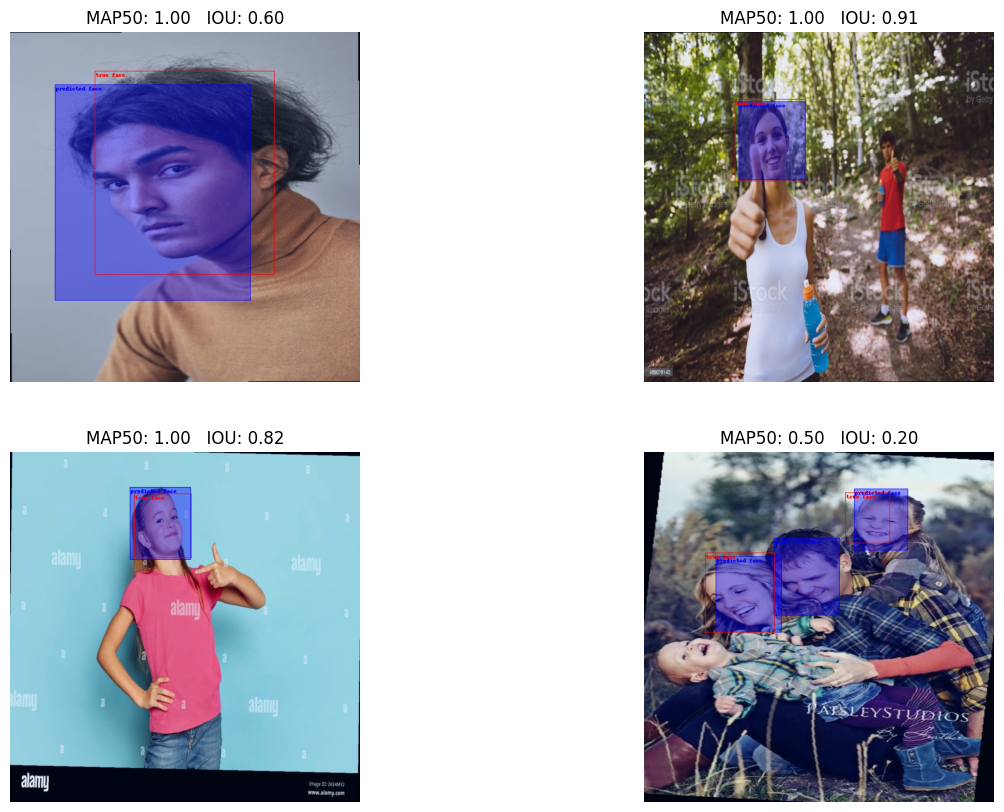

In [ ]:
index = np.random.randint(0, len(test_dataset), 4)
figure = plt.figure(figsize=(15,10))

for i in range(4):
    test = test_dataset[index[i]]
    look, IoU, MaP = draw_bb(test, model)

    title = (f'MAP50: {MaP:.2f}   IOU: {IoU["iou"]:.2f}')
    figure.add_subplot(2, 2, i + 1).set_title(title)
    plt.imshow(look.permute(1, 2, 0))
    plt.axis("off")

plt.show()

Красные bounding boxes - из датасета


Синие - предсказанные моделью

# Сохранение модели

In [ ]:
torch.save(model.state_dict(), '/content/ssd.pth')

In [ ]:
# Проверяем корректность загрузки
params_path = os.path.join('/content/ssd.pth')
new_model = model
new_model.load_state_dict(torch.load(params_path))

<All keys matched successfully>

# Лирическое отступление


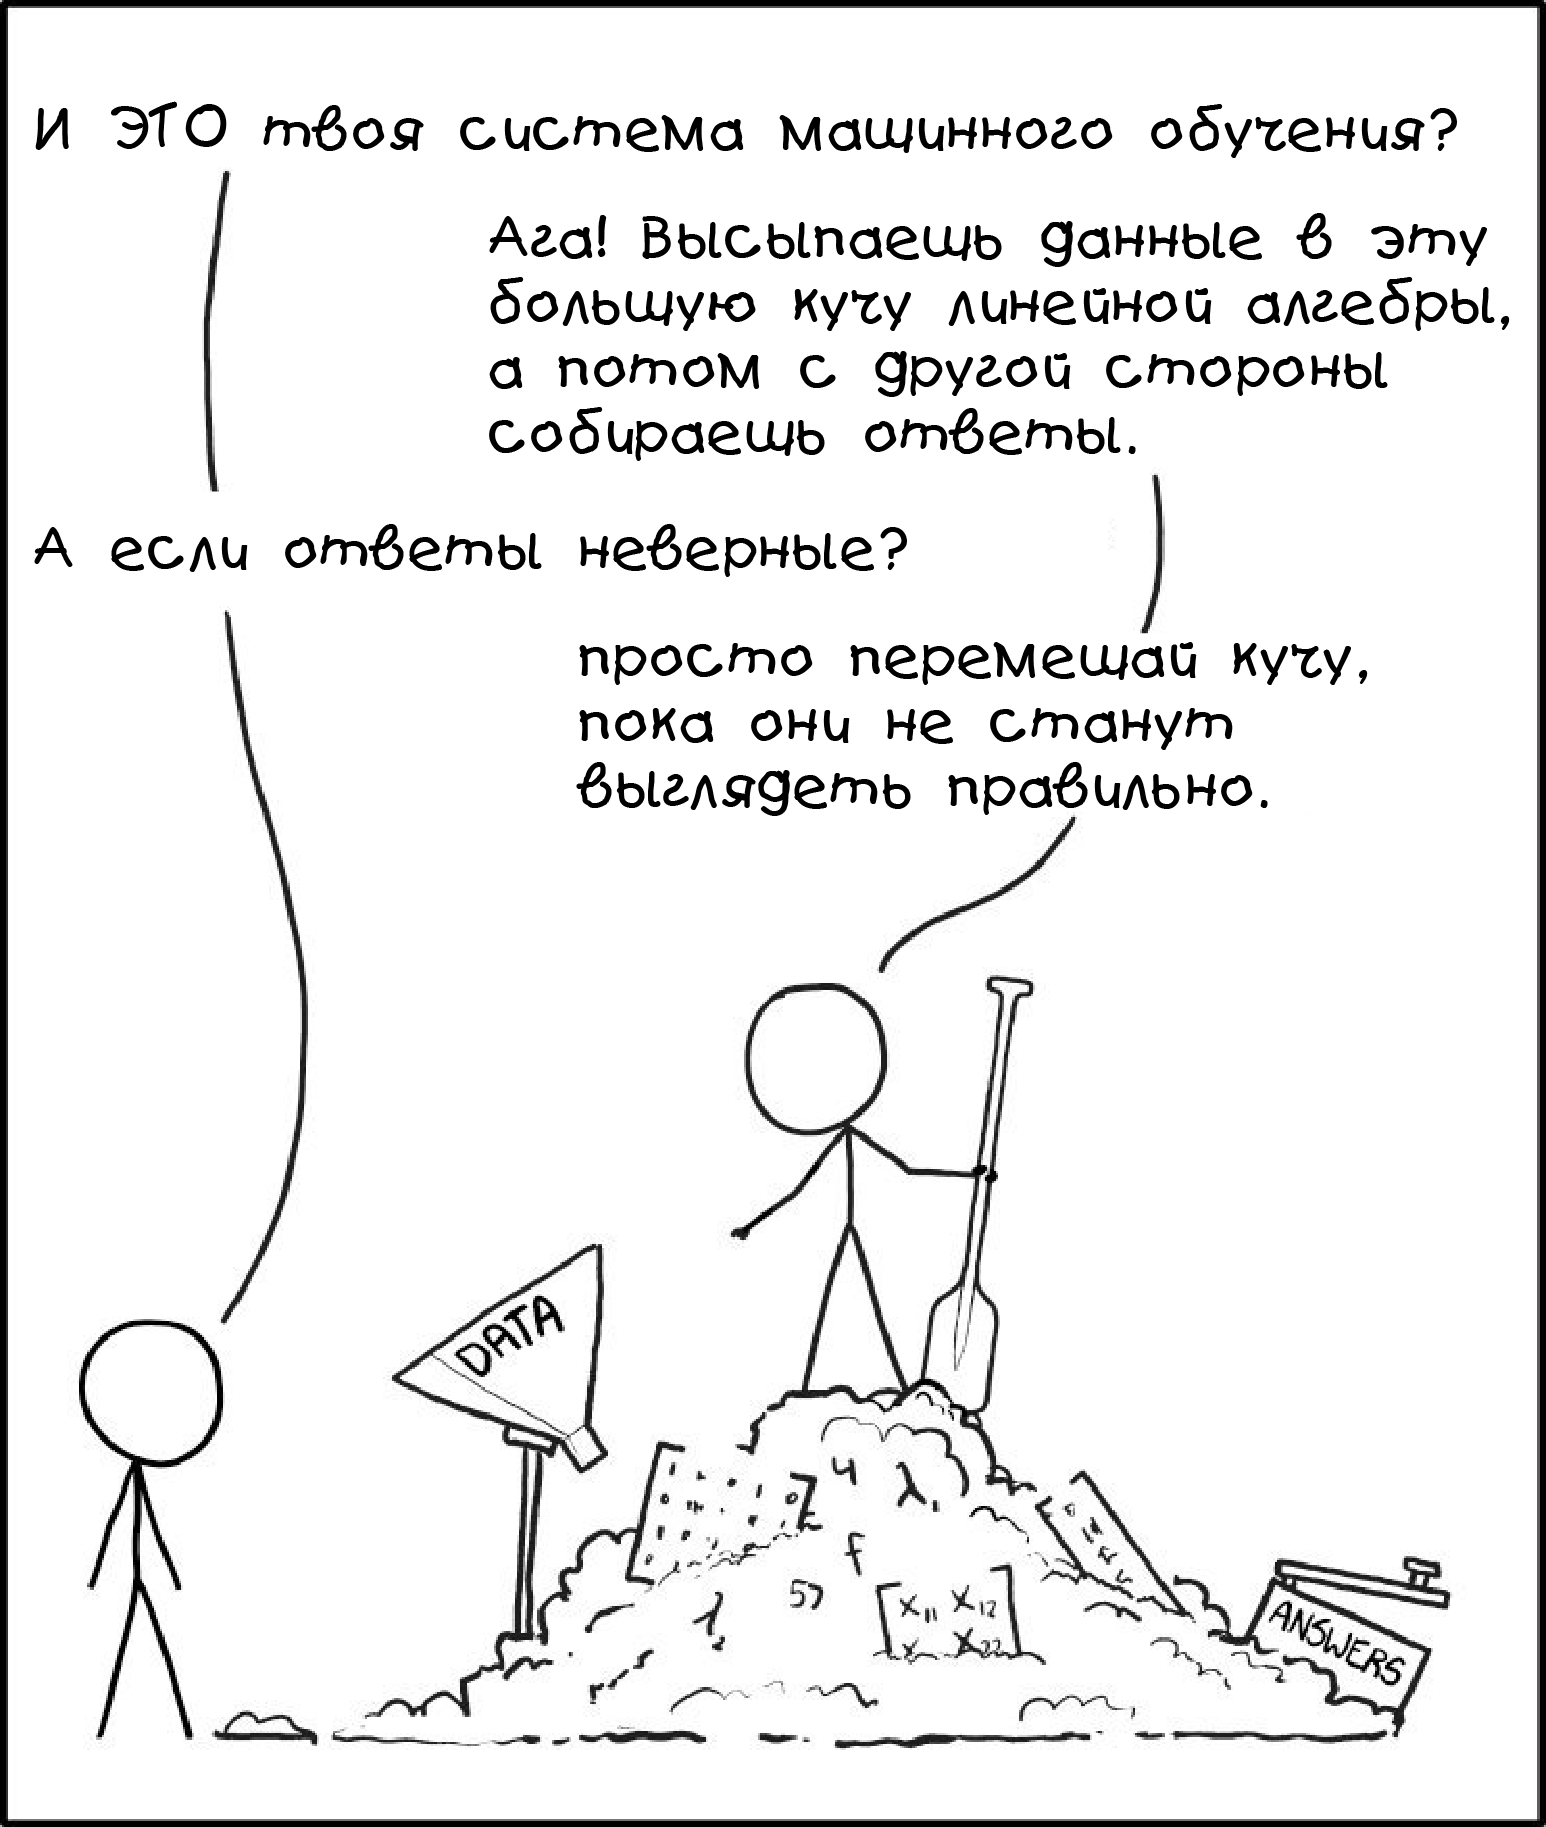

Идите в ML тут можно мемы в код вставлять